# Exploration of Neural Network libraries in Python:
# Training a Feedforward Neural Network for Regression

#### 1. Benchmark: Logistic Regression (scikit-learn)
    
#### 2. Classification
    2.1 Benchmark
    2.2 Keras NN
    2.3 Ensamble of models

#### 3. Regression
    3.1 Benchmark
    3.2 Keras NN
    
#### 4. Others
    4.1 PyBrain
    4.2 Tensorflow (Deep Neural Network Classifier)

In [56]:
import sys, os
sys.path.append(os.path.join(os.getcwd().split('ICM')[0], 'ICM', 'code'))
sys.path.append(os.path.join(os.getcwd().split('ICM')[0], 'ICM', 'code', 'notebooks', 'libs'))
import utils

In [52]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
# from sklearn.cross_validation import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils.np_utils import to_categorical

%matplotlib inline 
import time, math

In [53]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_AMELIA_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [54]:
df, labels = utils.process_amelia(DATA_AMELIA_FILE)

In [58]:
X_train_r, Y_train_r, X_test_r, Y_test_r = utils.get_train_test_data(df, regression=True, train_size=0.8)
X_train_c, Y_train_c, X_test_c, Y_test_c = utils.get_train_test_data(df, regression=False, train_size=0.8)

## 1. Benchmark Logistic Regression (Scikit-learn)

             precision    recall  f1-score   support

    1.5year       0.62      0.74      0.68       187
     4years       0.50      0.38      0.43       152
       more       0.63      0.66      0.65        79

avg / total       0.58      0.59      0.58       418

Accuracy: 0.5933014354066986
Mean square error (MSE): 0.54
R^2: 0.59


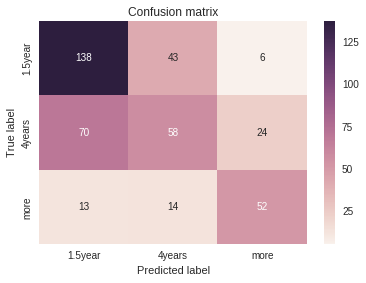

In [59]:
# Create logistic regression object
regr = linear_model.LogisticRegression()             
regr.fit(X_train_c, Y_train_c) 

Y_pred = regr.predict(X_test_c)
            
utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_c, Y_test_c) )  # Explained variance score

In [ ]:
# Regression

In [ ]:
regr = LinearSVC()
regr.fit(X_train_r, Y_train_r) 

Y_pred = regr.predict(X_test_r)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_r, Y_test_r) )  # Explained variance score

### 1.1 Benchmark Linear SVC

In [ ]:
svc = LinearSVC(random_state=0)
svc.fit(X_train_c, Y_train_c)

In [ ]:
Y_pred = svc.predict(X_test_c)
            
utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_c, Y_test_c) )  # Explained variance score

In [ ]:
# Regression

In [ ]:
svc = LinearSVC(random_state=0)
svc.fit(X_train_r, Y_train_r)

In [ ]:
Y_pred = svc.predict(X_test_r)
            
# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_r, Y_test_r) )  # Explained variance score

## 2.1 Classification: Benchmark

In [ ]:
# need the full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy_bin'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=54, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
results = cross_val_score(estimator, X, Y, cv=KFold(n=X.shape[0], n_folds=2, shuffle=True))
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## 2.1 Classification: Keras NN

In [ ]:
seed = 7
np.random.seed(seed)

model = Sequential()
# model.add(Dense(108, input_shape=(54,), kernel_initializer='normal', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(32, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

model.add(Dense(64, activation='relu', input_dim=54))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# model.add(Dense(input_dim=54, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=12, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(output_dim=1, activation='softmax'))
# model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

# 3
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)

# 4
#model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

model.summary()

hist = model.fit(np.array(X_train), np.array(to_categorical(Y_train)), 
                 epochs=600, batch_size=128,  verbose=1, validation_split=0.3)#, callbacks=[tbCallBack])

In [ ]:
utils.plot_hist(hist)

In [ ]:
hist = model.fit(np.array(X_train), np.array(to_categorical(Y_train)), 
                 epochs=120, batch_size=128,  verbose=0, validation_split=0.3)#, callbacks=[tbCallBack])

In [ ]:
Y_pred = model.predict(np.array(X_test))

In [ ]:
Y_pred = Y_pred.argmax(axis=-1)

In [ ]:
utils.plot_report(Y_test, Y_pred, labels)

## 2.3 Classification: Ensamble of models

In [ ]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_dim = 54, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
mp = mlp_model()

In [ ]:
hist = mp.fit(np.array(X_train_c), np.array(to_categorical(Y_train_c)), epochs=600, batch_size=128,  verbose=0, 
              validation_split=0.3)#, callbacks=[tbCallBack])

In [ ]:
utils.plot_hist(hist)

In [ ]:
# create 5 models to ensemble
model1 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 150)

ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), 
                                              ('model3', model3), ('model4', model4), 
                                              ('model5', model5)], voting = 'soft')

In [ ]:
ensemble_clf.fit(np.array(X_train), np.array(Y_train))

In [ ]:
Y_pred = ensemble_clf.predict(np.array(X_test))

In [ ]:
utils.plot_report(Y_test, Y_pred, labels)

## 3.1 Regression: Benchmark

In [ ]:
def test_kfolds(regressor, x, y, kfolds = [5]):
    for k_folds in kfolds:
        # evaluate model with standardized dataset
        np.random.seed(182)
        estimators = []
        #estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', regressor))
        pipeline = Pipeline(estimators)
        kfold = KFold(n=X.shape[0], n_folds=k_folds)
        results = cross_val_score(pipeline, x, y, cv=kfold)
        print("K_folds {}: \nMean {} \nStd {}".format(k_folds, results.mean(), results.std()))

In [ ]:
# Need full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=54, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.MAPE,
                                                                        metrics.MSLE,
                                                                        metrics.MAE])
    return model

In [ ]:
bm = baseline_model()
hist = bm.fit(np.array(X_train_r), np.array(Y_train_r), 
                 epochs=600, batch_size=128,  verbose=0, validation_split=0.3)

In [ ]:
utils.plot_hist(hist)

In [ ]:
test_kfolds(KerasRegressor(build_fn=baseline_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

In [ ]:
bm.evaluate(np.array(X_test_r), np.array(Y_test_r))

## 3.2 Regression: Keras NN

In [ ]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(54, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(27, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
test_kfolds(KerasRegressor(build_fn=larger_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

In [ ]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(540, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(270, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
test_kfolds(KerasRegressor(build_fn=wider_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

## 3.3 Model showdown

Different approach for Classification vs. Regression using Neural Network:
- Training examples: Rn x {class_1, ..., class_n} (one-hot encoding) vs Rn x Rm
- Last layer: softmax vs linear / sigmoid
- Loss function: Cross entropy vs MSE / Absolute error

In [ ]:
model = Sequential()
model.add(Dense(50, kernel_initializer="normal", input_dim=54))
model.add(Activation('relu'))
model.add(Dense(1))
    
model.compile(optimizer = optimizers.SGD(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

history = model.fit(np.array(X_train), np.array(Y_train), epochs = 100, verbose = 1)

# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.legend(['training', 'validation'], loc = 'upper left')
# plt.show()

results = model.evaluate(np.array(X_test), np.array(Y_test))
print('\nTest accuracy: ', results[1])

In [ ]:
model.summary()

## 4. Others

In [ ]:
#!pip install git+https://github.com/pybrain/pybrain.git

### 3.1 PyBrain: Regression

In [ ]:
from pybrain.structure import SigmoidLayer, LinearLayer, TanhLayer, ReluLayer, SoftmaxLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pybrain.tools.shortcuts as pb
import numpy, math

# Build the dataset
xvalues = np.array(X_train_r)
yvalues = np.array(Y_train_r)
ds = SupervisedDataSet(54, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x), (y))
    
# Build the NN
nn1 = pb.buildNetwork(54,  # 1 input node
                   #108,    # number of nodes in 1st hidden layer
                   54,     # number of nodes in 4th hidden layer
                   1,     # 1 output node
                   bias = False,
                   hiddenclass = SigmoidLayer,
                   outclass = LinearLayer )

# Train the NN
trainer = BackpropTrainer(nn1, ds, learningrate = 0.01, weightdecay=0.01, momentum=0.02) #, verbose = True)
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 20, continueEpochs=5, validationProportion=0.25)

##### Note on some of the parameters

**validationProportion**: ratio of the dataset that is used for the validation dataset.
If maxEpochs is given, at most that many epochs are trained. Each time validation error hits a minimum, try for continueEpochs # epochs to find a better one.

**Epoch**: one epoch means that every example has been seen once. It is preferable to track epochs rather than iterations since 
the number of iterations depends on the arbitrary setting of batch size. Batchs are used for example in the minibatch method,
for example, for 1000 examples, the NN is trained on examples 1-100, then examples 101-201, etc.

**Momentum**: 0 < m < 1 is a global parameter which must be determined by trial and error. Momentum simply adds a fraction m of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate µ when using a lot of momentum (m close to 1). If you combine a high learning rate with a lot of momentum, you will rush past the minimum with huge steps! When the gradient keeps changing direction, momentum will smooth out the variations. Adding a momentum can help to speed up convergence to the minimum by damping oscillations.

In [ ]:
# Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()

## 4.2 Tensorflow Deep Neural Network Classifier

In [7]:
from dnn_classifier import DNNClassifier
from sklearn.metrics import accuracy_score

In [8]:
dnn = DNNClassifier(show_progress=10, random_state=42)
dnn.fit(np.array(X_train_c), np.array(Y_train_c), n_epochs=100)

Y_pred = dnn.predict(X_test_c)
print("Score on test set: {:.2f}%".format(accuracy_score(Y_test_c, Y_pred) * 100))

Epoch: 1 Current training accuracy: 0.5500
Epoch: 11 Current training accuracy: 0.6000
Epoch: 21 Current training accuracy: 0.4000
Epoch: 31 Current training accuracy: 0.6000
Epoch: 41 Current training accuracy: 0.7000
Epoch: 51 Current training accuracy: 0.7000
Epoch: 61 Current training accuracy: 0.5000
Epoch: 71 Current training accuracy: 0.6500
Epoch: 81 Current training accuracy: 0.6500
Epoch: 91 Current training accuracy: 0.8000


### Try dropout to reduce overfitting

In [ ]:
dnn = DNNClassifier(dropout_rate=0.25, show_progress=10, random_state=42)
dnn.fit(np.array(X_train_c), np.array(Y_train_c), n_epochs=1000)

Y_pred = dnn.predict(X_test_c)
print("Score on test set: {:.2f}%".format(accuracy_score(Y_test_c, Y_pred) * 100))

Epoch: 1 Current training accuracy: 0.4500
Epoch: 11 Current training accuracy: 0.6000
Epoch: 21 Current training accuracy: 0.5000
